# Qiskit Assignment 2

## Elitzur-Vaidman Bomb
Today you will be implementing the EV Bomb experiment.

**NAME**: REPLACE WITH YOUR NAME

**STUDENT ID**: REPLACE WITH YOUR STUDENT ID

In [1]:
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import re

#### Task 1 - Establishing the Required Iterations (10 pts)
First let's compute the number of iterations through the loop we need to be arbitrarily confident that there won't be an explosion during our experiment. Write a function `compute_iterations` that takes an input `probability`, *in decimal form*, and returns `n`, the number of iterations needed to be (`probability`$\times 100$)% confident that there will **not** be an explosion. Round $n$ to the next highest integer. 

In [2]:
def compute_iterations(probability):
    # BEGIN SOLUTION
    n = (np.pi**2) / (4*(1-probability))
    return round(n)
    # END SOLUTION

In [3]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_iterations(0.5) == 5

True

In [4]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_iterations(0.99) == 247

True

In [5]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_iterations(0.99473) == 468

True

In [6]:
""" # BEGIN TEST CONFIG
hidden: true
points: 7
failure_message: Wrong answer.
""" # END TEST CONFIG
def testComputeIterations():
    for n in range(1,1000):
        probability = n / 1000
        solution_ans = round((np.pi**2) / (4*(1-probability)))
        student_ans = compute_iterations(probability)
        if student_ans != solution_ans:
            return False
    return True

testComputeIterations()

True

#### Task 2 - Computing Theta (10 pts)
We know the number of iterations we need to be arbitrarily confident the bomb won't explode. Now let's calculate the angle we need to rotate through at each step of iteration, $\theta$. Write a function `compute_theta(n)` that takes `n` as input and returns $\theta$. Round $\theta$ to the nearest 5 decimal places.

In [7]:
def compute_theta(n):
    # BEGIN SOLUTION
    theta = round(np.pi/n,5)
    return theta
    # END SOLUTION

In [8]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong number of decimal places.
""" # END TEST CONFIG
rounding_re = re.compile(r"^([\d]{1}).([\d]{5})$")
def testNumDecimalPlaces():
    theta = compute_theta(10)
    success = True
    return False if rounding_re.match(str(theta)) is None else True
  
testNumDecimalPlaces()

True

In [9]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_theta(15) == 0.20944

True

In [10]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
compute_theta(25) == 0.12566

True

In [11]:
""" # BEGIN TEST CONFIG
hidden: true
points: 7
failure_message: Wrong answer.
""" # END TEST CONFIG
def testComputeTheta():
    for n in range(1,1000):
        solution_ans = round(np.pi/n,5)
        student_ans = compute_theta(n)
        if student_ans != solution_ans:
            return False
    return True

testComputeTheta()

True

#### Task 3 - Rotation (10 pts)
Write a function `rotate(qc,theta)` that takes an input QuantumCircuit `qc` and an input `theta`. The function should rotate the state on the first qubit by `theta` radians about the $y$-axis of the Bloch sphere. Return the modified circuit.

In [12]:
def rotate(qc, theta):
    # BEGIN SOLUTION
    qc.ry(theta, 0)
    return qc
    # END SOLUTION

In [13]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilities1():
    qc = QuantumCircuit(1,1)
    theta = np.pi
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities1()  == [0,1]

True

In [14]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilities2():
    qc = QuantumCircuit(1,1)
    theta = np.pi / 2
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities2() == [1/np.sqrt(2), 1/np.sqrt(2)]

True

In [15]:
""" # BEGIN TEST CONFIG
hidden: false
points: 1
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilities3():
    qc = QuantumCircuit(1,1)
    theta = 2 * np.pi / 3
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return [round(num, 5) for num in job.result().get_statevector().real]

testProbabilities3() == [round(num, 5) for num in [1/2, np.sqrt(3)/2]]

True

In [28]:
""" # BEGIN TEST CONFIG
hidden: true
points: 7
failure_message: Wrong answer.
""" # END TEST CONFIG
def testProbabilitiesHidden():
    em = BasicAer.get_backend("qasm_simulator")
    passing = True
    for i in range(360):
        theta = i * np.pi/180
        qc_student = rotate(QuantumCircuit(1,1), theta)
        qc_solution = QuantumCircuit(1,1)
        qc_solution.u(theta, 0, 0, 0)
        equivalent = Statevector.from_instruction(qc_student).equiv(Statevector.from_instruction(qc_solution))
        if not equivalent:
            passing = False
    return passing

testProbabilitiesHidden()

True

We provide the below method `bomb_oracle()` to randomly decide to include a bomb or not in our experiment.

In [18]:
random.seed(468)

def bomb_oracle():
    if random.random() < 0.5:
        return "bomb"
    else:
        return "empty"

We also provide some helper methods below. 

`genQC(n)` generates a QuantumCircuit with 1 qubit and n classical bits. 

`identity(qc)` applies an identity gate to `qc`'s qubit. 

`measure(qc, i=0)` applies a measurment from `qc`'s qubit to the $i$th classical bit.

In [19]:
def genQC(n):
    qc = QuantumCircuit()
    qr = QuantumRegister(1,'qr')
    cr = ClassicalRegister(n, 'step')
    rs = ClassicalRegister(1, 'result')
    qc.add_register(qr)
    qc.add_register(cr)
    qc.add_register(rs)
    return qc

def identity(qc):
    qr = getQR(qc)
    qc.id(qr)
    return qc

def measure(qc, i=0):
    qr = getQR(qc)
    cr = getCR(qc, i)
    qc.measure(qr,cr)
    return qc

def getQR(qc):
    return qc.qregs[0]

def getCR(qc, i):
    return qc.cregs[0][i]

#### Task 4  - Putting Things Together (40 pts)
We are now ready to build the full circuit. Write a function `gen_circuit(probability, bomb)` which takes a `probability` that the bomb won't explode, `bomb`--the result of a call to `bomb_oracle()`, and returns a circuit representing the standard EV bomb implementation. For our experiment, we will represent the bomb being present with a measurement and the bomb being absent with an identity. 

Hint: use the provided functions and previous tasks to help build your circuit. Refer to the end of lecture for a description of the implementation.

In [20]:
def gen_circuit(probability, bomb):
    # BEGIN SOLUTION
    n = compute_iterations(probability)
    angle = compute_theta(n)
    qc = genQC(n)
    
    for i in range(n):
        rotate(qc, angle)
        if bomb == "bomb":
            measure(qc,i)
        else:
            identity(qc)
    
    # END SOLUTION
    # Add one final measurement without rotation
    # to the result register
    qc.measure(getQR(qc), qc.cregs[1])
    return qc

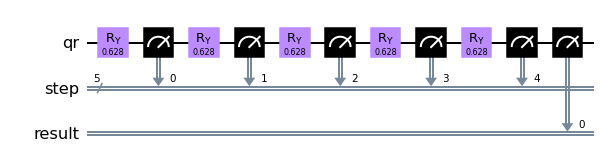

In [21]:
# Draw a bomb circuit here having probability == 0.5
# BEGIN SOLUTION
qc = gen_circuit(0.5, "bomb")
qc.draw(output='mpl')
# END SOLUTION

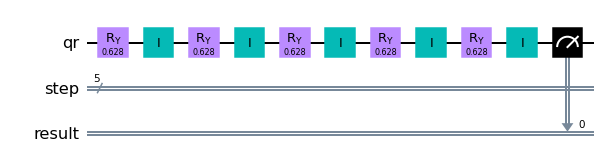

In [22]:
# Draw an empty circuit here having probability == 0.5
# BEGIN SOLUTION
qc = gen_circuit(0.5, "empty")
qc.draw(output='mpl')
# END SOLUTION

#### Task 5  - Testing your Circuit (10 pts)
Run the code below a few times and observe the output. 
- What does measuring $|0\rangle$ or $|1\rangle$ each tell us about the the presence of a bomb?
- Does your circuit blow up a reasonable percentage of the time? Save a chart in your notebook that shows this ratio for a "bomb" circuit and describe it in your response below.

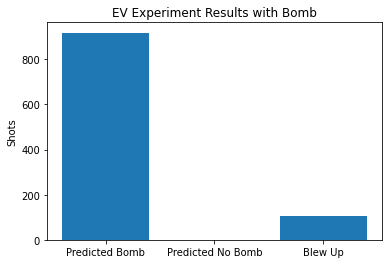

In [24]:
qasm_sim = BasicAer.get_backend("qasm_simulator")

def em(qc, shots=1024):
    job = execute(qc, qasm_sim, shots=shots)
    counts = job.result().get_counts()
    return counts

def run_circuit(percentage,bomb):
    qc = gen_circuit(percentage,bomb)
    counts = em(qc)
    n = compute_iterations(percentage)
    
    zeros_key = "0 " + "0"*n
    one_key = "1 "+"0"*n
    
    predicted_bomb = 0
    predicted_no_bomb = 0
    blew_up = 0

    if zeros_key in counts:
        predicted_bomb = counts[zeros_key]
    if one_key in counts:
        predicted_no_bomb = counts[one_key]
        
    blew_up = 1024 - predicted_bomb - predicted_no_bomb
    
    y = np.arange(3)
    plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
    plt.ylabel("Shots")
    plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
    if bomb == "bomb":
        plt.title("EV Experiment Results with Bomb")
    else:
        plt.title("EV Experiment Results with No Bomb")
    plt.show()
    
    return None

bomb = bomb_oracle()
run_circuit(0.9, bomb)

$|1\rangle$ represents the case of no bomb present. $|0\rangle$ represents the expected state when a bomb is present. If there is a bomb, we'd see it according to the probability established for the trial.

The chart shows that roughly 100 out of 1024 trials resulted in an explosion with a bomb present. This is aligned with the probability set for the experiment.

#### Task 6 (6A, 6B) - EV Bomb on an IBM Quantum Computer (20 pts)
Finally, let's run this circuit on a real quantum computer. 
- Set the experiment probability to be `0.9`
- Ensure the presence of a bomb
- Store the measurement results in `counts`

ibmqfactory.load_account:WARNING:2021-12-31 09:58:00,477: Credentials are already in use. The existing account in the session will be replaced.


Check job status here: https://quantum-computing.ibm.com/jobs/61cf1a7c0e8ecb665519ec23


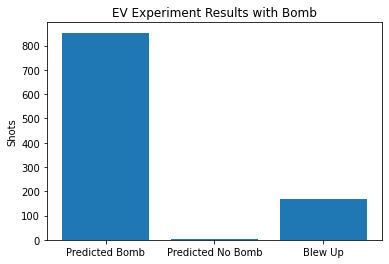

In [26]:
# run your circuit here

# BEGIN SOLUTION
IBMQ.load_account()
ibmqc = IBMQ.get_provider(hub='ibm-q').get_backend('ibmq_')
job = execute(gen_circuit(.9, "bomb"), ibmqc, shots=1024)
print("Check job status here:", "https://quantum-computing.ibm.com/jobs/" + job.job_id())
res = job.result()
counts = res.get_counts()
# END SOLUTION

n = compute_iterations(.9)
zeros_key = "0 " + "0"*n
one_key = "1 "+ "0"*n

predicted_bomb = 0
predicted_no_bomb = 0
blew_up = 0

if zeros_key in counts:
    predicted_bomb = counts[zeros_key]
if one_key in counts:
    predicted_no_bomb = counts[one_key]

blew_up = 1024 - predicted_bomb - predicted_no_bomb

y = np.arange(3)
plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
plt.ylabel("Shots")
plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
plt.title("EV Experiment Results with Bomb")
plt.show()

Did your circuit blow up a reasonable percentage of the time on the quantum computer? Save a chart in your notebook that shows this ratio and describe it in your response below. Was there any difference between the simulator and quantum computer results? If there was, what might account for it?

The ratio looks similar although there were about twice as many explosions when running on the quantum computer (at least when this solution was made) as in the simulator. This is likely caused by the noise (gate error, decoherence) inherent in the real quantum computer.

Next time: multi-qubit circuits!